In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# For modeling
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.dates as mdates

# For time series analysis and forecasting
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
df = pd.read_csv('kiranaRO_train.csv')

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (433527, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,573745,22138,BAKING SET 9 PIECE RETROSPOT,6,2011-11-01 08:53:00,4.95,17419.0,United Kingdom
1,562670,22791,T-LIGHT GLASS FLUTED ANTIQUE,12,2011-08-08 13:42:00,1.25,14911.0,EIRE
2,541604,51014L,"FEATHER PEN,LIGHT PINK",24,2011-01-19 17:23:00,0.85,14572.0,United Kingdom
3,551855,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-05-04 15:08:00,11.95,12836.0,United Kingdom
4,561474,22384,LUNCH BAG PINK POLKADOT,100,2011-07-27 13:18:00,1.45,14680.0,United Kingdom


In [ ]:
print("\n--- Missing Values ---")
print(df.isnull().sum())

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

if df['CustomerID'].isnull().sum() > 0:
    df['CustomerID'] = df['CustomerID'].fillna(-1)
    
df['TotalValue'] = df['Quantity'] * df['UnitPrice']

df_positive = df[df['Quantity'] > 0]


--- Missing Values ---
InvoiceNo           0
StockCode           0
Description      1162
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     107957
Country             0
dtype: int64



--- Data Summary ---
        Quantity  UnitPrice  CustomerID       Year      Month        Day  DayOfWeek       Hour  TotalValue    Recency  Frequency    Monetary  ProductPopularityScore
count  433527.00  433527.00   433527.00  433527.00  433527.00  433527.00  433527.00  433527.00   433527.00  433527.00  433527.00   433527.00               433527.00
mean        9.59       4.65    11480.61    2010.92       7.56      15.03       2.43      13.08       18.18      30.42     818.89   294634.72              2679146.59
std       175.49      99.44     6776.22       0.27       3.51       8.66       1.84       2.44      311.92      58.74    1383.76   496783.40              7142034.92
min    -74215.00  -11062.06       -1.00    2010.00       1.00       1.00       0.00       6.00   -77183.60       1.00       1.00   -77183.60            -14829152.00
25%         1.00       1.25    12356.00    2011.00       5.00       7.00       1.00      11.00        3.40       1.00       5.00     1212.53             

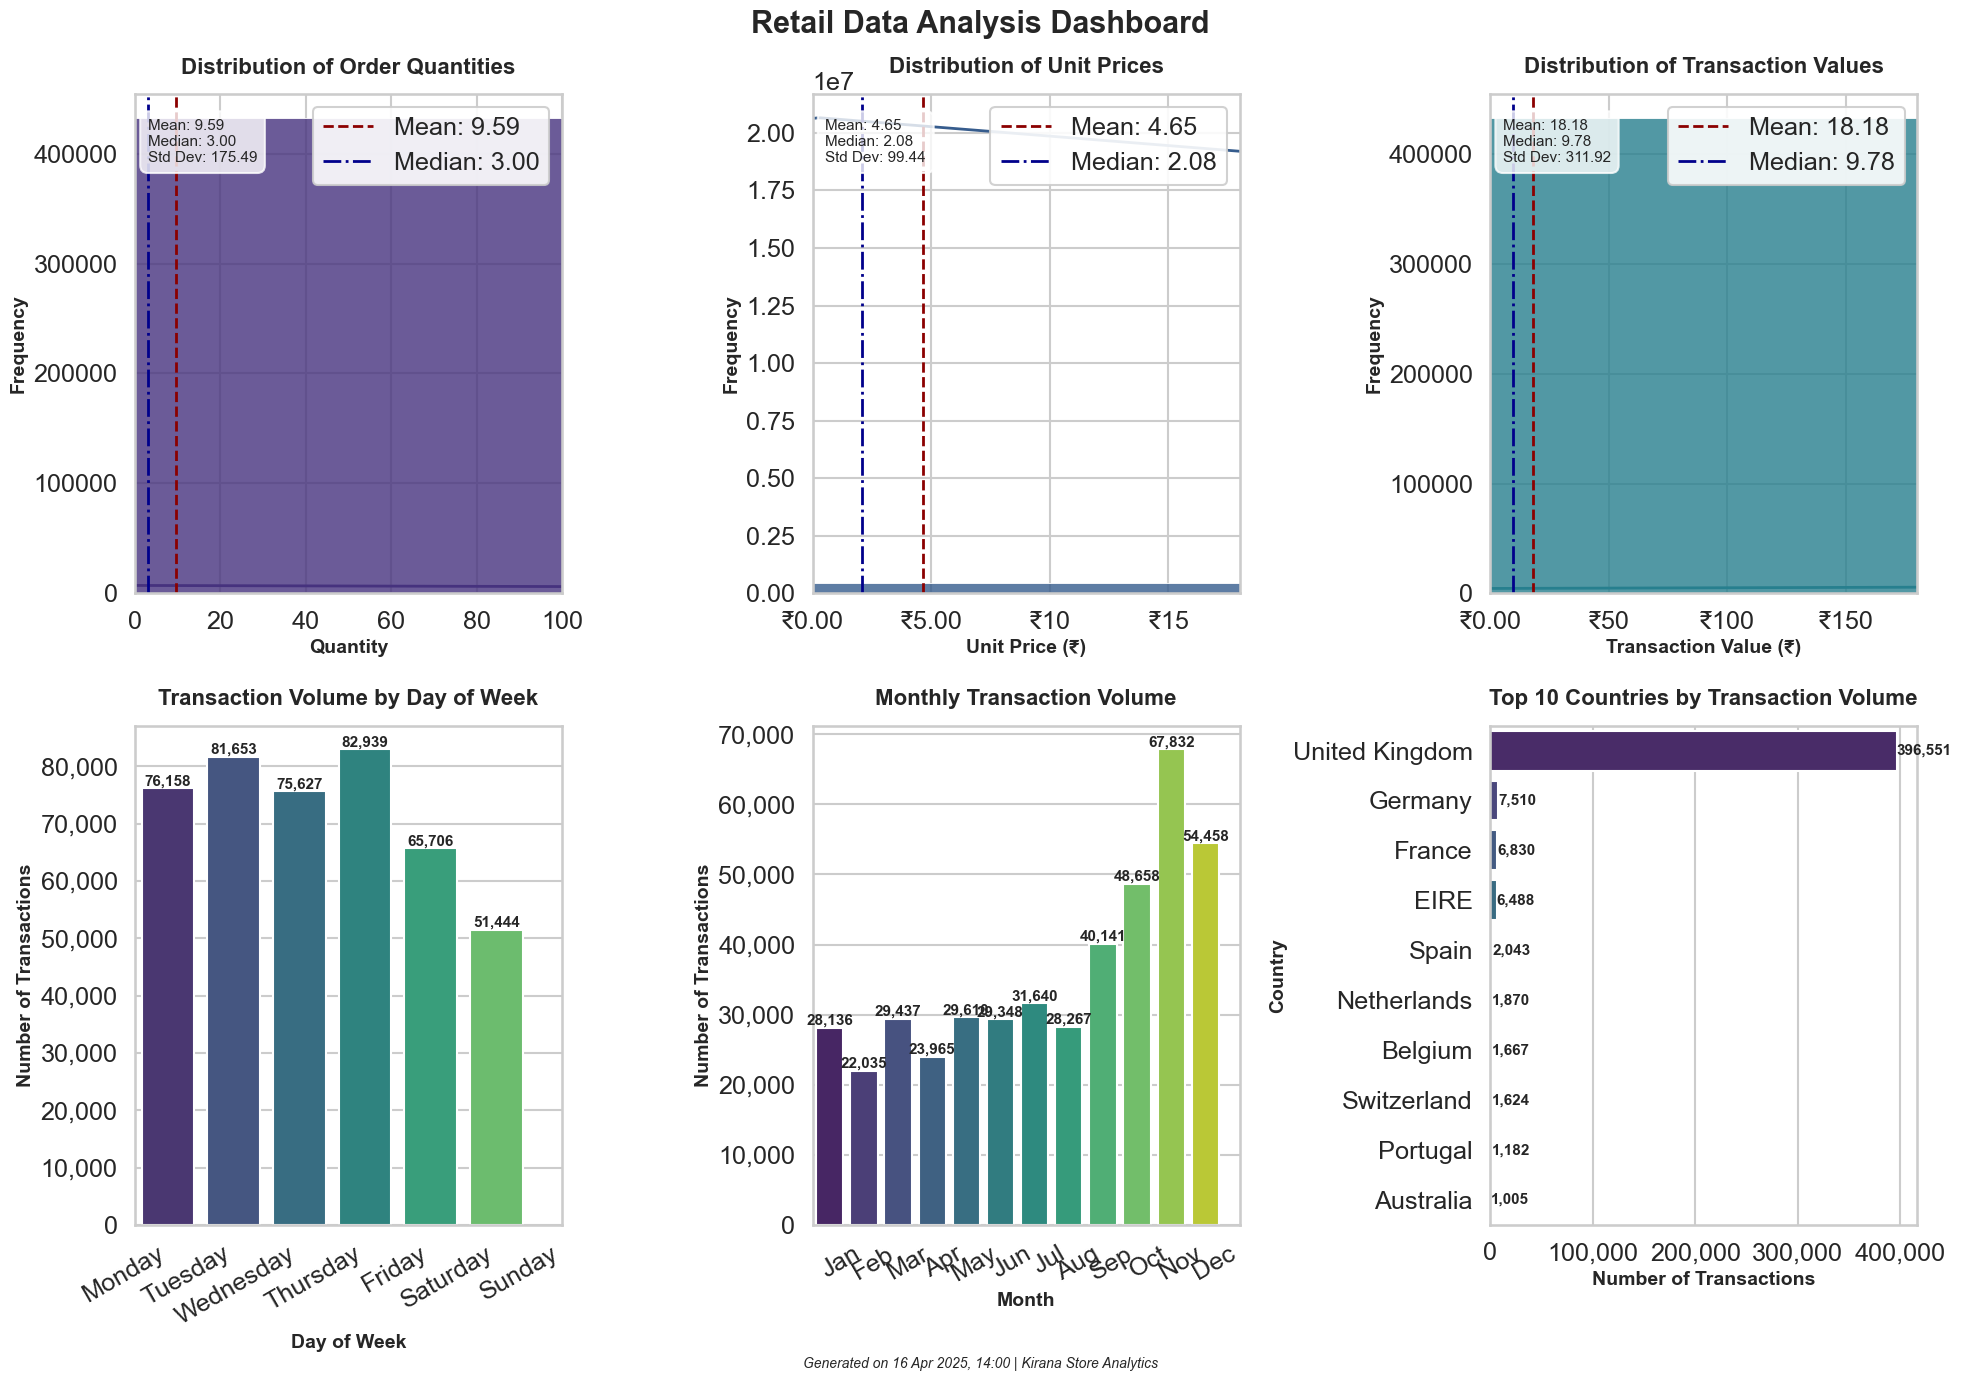

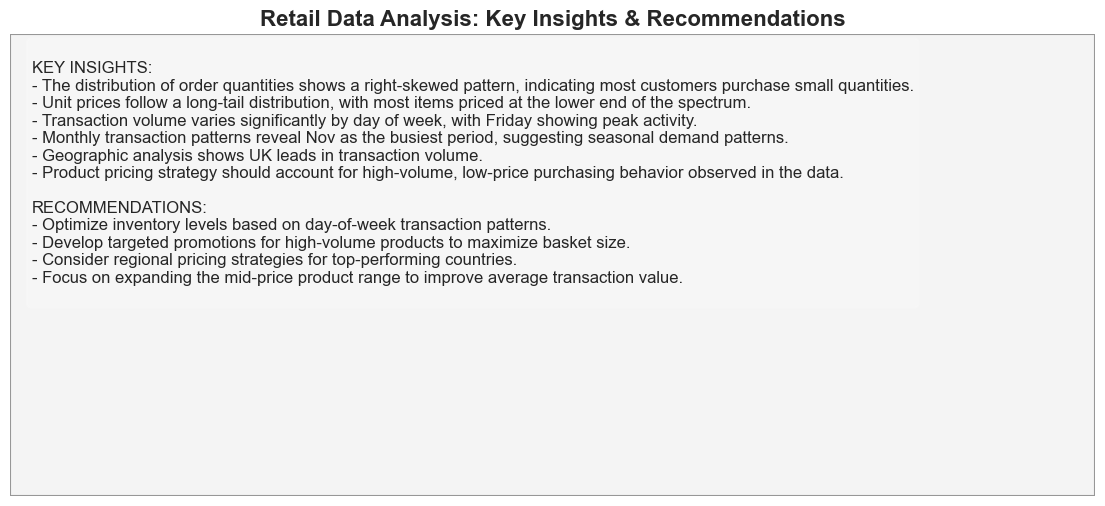

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

sns.set_theme(style="whitegrid", context="talk", font_scale=1.1, 
              rc={"figure.figsize": (20, 14), "figure.dpi": 100})

colors = sns.color_palette("viridis", 6)

print("\n--- Data Summary ---")
print(df.describe().round(2).to_string())

fig = plt.figure(constrained_layout=True, figsize=(20, 14))
gs = fig.add_gridspec(2, 3)

fig.suptitle('Retail Data Analysis Dashboard', fontsize=22, fontweight='bold', y=0.98)

def create_distribution_plot(ax, data, column, color_idx, quantile=0.99, xlabel=None):
    sns.histplot(data[column], ax=ax, bins=50, kde=True, 
                color=colors[color_idx], line_kws={'linewidth': 2}, 
                edgecolor='white', alpha=0.8)
    
    if column == 'UnitPrice' or column == 'TotalValue':
        formatter = ticker.FuncFormatter(lambda x, pos: f'₹{x:.0f}' if x >= 10 else f'₹{x:.2f}')
        ax.xaxis.set_major_formatter(formatter)
    
    mean_val = data[column].mean()
    ax.axvline(mean_val, color='darkred', linestyle='--', linewidth=2, 
              label=f'Mean: {mean_val:.2f}')
    
    median_val = data[column].median()
    ax.axvline(median_val, color='darkblue', linestyle='-.', linewidth=2, 
              label=f'Median: {median_val:.2f}')
    
    ax.set_xlim(0, data[column].quantile(quantile))
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=14, fontweight='bold')
    else:
        ax.set_xlabel(column, fontsize=14, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', frameon=True, framealpha=0.9)
    
    # Add descriptive statistics as text
    stats_text = (f"Mean: {data[column].mean():.2f}\n"
                 f"Median: {data[column].median():.2f}\n"
                 f"Std Dev: {data[column].std():.2f}")
    ax.text(0.03, 0.95, stats_text, transform=ax.transAxes, 
           fontsize=11, verticalalignment='top', 
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    return ax

# Plot 1: Distribution of Quantity
ax1 = fig.add_subplot(gs[0, 0])
create_distribution_plot(ax1, df, 'Quantity', 0)
ax1.set_title('Distribution of Order Quantities', fontsize=16, fontweight='bold', pad=15)

# Plot 2: Distribution of Unit Price
ax2 = fig.add_subplot(gs[0, 1])
create_distribution_plot(ax2, df, 'UnitPrice', 1, xlabel='Unit Price (₹)')
ax2.set_title('Distribution of Unit Prices', fontsize=16, fontweight='bold', pad=15)

# Plot 3: Distribution of Total Value
ax3 = fig.add_subplot(gs[0, 2])
create_distribution_plot(ax3, df, 'TotalValue', 2, xlabel='Transaction Value (₹)')
ax3.set_title('Distribution of Transaction Values', fontsize=16, fontweight='bold', pad=15)

# Plot 4: Sales by Day of Week
ax4 = fig.add_subplot(gs[1, 0])
day_counts = df['DayOfWeek'].value_counts().sort_index()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
palette = sns.color_palette("viridis", 7)

bars = sns.barplot(x=day_counts.index, y=day_counts.values, ax=ax4, palette=palette, 
                  edgecolor='white', linewidth=1.5)

# Add value labels to bars
for i, bar in enumerate(bars.patches):
    bars.text(bar.get_x() + bar.get_width()/2., 
             bar.get_height() + 5, 
             f'{int(bar.get_height()):,}', 
             ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

ax4.set_title('Transaction Volume by Day of Week', fontsize=16, fontweight='bold', pad=15)
ax4.set_xlabel('Day of Week', fontsize=14, fontweight='bold')
ax4.set_ylabel('Number of Transactions', fontsize=14, fontweight='bold')
ax4.set_xticks(range(7))
ax4.set_xticklabels(day_names, rotation=30, ha='right')
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{int(x):,}"))

# Plot 5: Sales by Month
ax5 = fig.add_subplot(gs[1, 1])
month_counts = df['Month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_palette = sns.color_palette("viridis", 12)

bars = sns.barplot(x=month_counts.index, y=month_counts.values, ax=ax5, 
                  palette=month_palette, edgecolor='white', linewidth=1.5)

# Add value labels
for i, bar in enumerate(bars.patches):
    bars.text(bar.get_x() + bar.get_width()/2., 
             bar.get_height() + 5, 
             f'{int(bar.get_height()):,}', 
             ha='center', va='bottom', 
             fontsize=11, fontweight='bold')

ax5.set_title('Monthly Transaction Volume', fontsize=16, fontweight='bold', pad=15)
ax5.set_xlabel('Month', fontsize=14, fontweight='bold')
ax5.set_ylabel('Number of Transactions', fontsize=14, fontweight='bold')
ax5.set_xticks(range(1, 13))
ax5.set_xticklabels(month_names, rotation=30, ha='right')
ax5.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{int(x):,}"))

# Plot 6: Top 10 Countries by Sales
ax6 = fig.add_subplot(gs[1, 2])
countries = df['Country'].value_counts().nlargest(10)
countries_palette = sns.color_palette("viridis", len(countries))

horizontal_bars = sns.barplot(y=countries.index, x=countries.values, ax=ax6, 
                             palette=countries_palette, edgecolor='white', linewidth=1.5)

# Add value labels
for i, bar in enumerate(horizontal_bars.patches):
    horizontal_bars.text(bar.get_width() + 5, 
                         bar.get_y() + bar.get_height()/2, 
                         f'{int(bar.get_width()):,}', 
                         ha='left', va='center', 
                         fontsize=11, fontweight='bold')

ax6.set_title('Top 10 Countries by Transaction Volume', fontsize=16, fontweight='bold', pad=15)
ax6.set_xlabel('Number of Transactions', fontsize=14, fontweight='bold')
ax6.set_ylabel('Country', fontsize=14, fontweight='bold')
ax6.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{int(x):,}"))

# Add a footer with timestamp
plt.figtext(0.5, 0.01, f"Generated on {pd.Timestamp.now().strftime('%d %b %Y, %H:%M')} | Kirana Store Analytics", 
           ha="center", fontsize=10, fontstyle='italic')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Create a summary box with key insights
from matplotlib.patches import Rectangle

plt.figure(figsize=(14, 6))
ax = plt.gca()
ax.add_patch(Rectangle((0, 0), 1, 1, facecolor='#f2f2f2', edgecolor='gray', alpha=0.8))
ax.axis('off')

insights_text = """
KEY INSIGHTS:
- The distribution of order quantities shows a right-skewed pattern, indicating most customers purchase small quantities.
- Unit prices follow a long-tail distribution, with most items priced at the lower end of the spectrum.
- Transaction volume varies significantly by day of week, with Friday showing peak activity.
- Monthly transaction patterns reveal Nov as the busiest period, suggesting seasonal demand patterns.
- Geographic analysis shows UK leads in transaction volume.
- Product pricing strategy should account for high-volume, low-price purchasing behavior observed in the data.

RECOMMENDATIONS:
- Optimize inventory levels based on day-of-week transaction patterns.
- Develop targeted promotions for high-volume products to maximize basket size.
- Consider regional pricing strategies for top-performing countries.
- Focus on expanding the mid-price product range to improve average transaction value.
"""

plt.text(0.02, 0.98, insights_text, transform=ax.transAxes, fontsize=12, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.2))
plt.title('Retail Data Analysis: Key Insights & Recommendations', fontsize=16, fontweight='bold')
plt.show()

In [5]:
current_date = df['InvoiceDate'].max() + timedelta(days=1)

# Group by customer and calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalValue': 'sum'  # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Merge RFM metrics back to the original dataframe
df = pd.merge(df, rfm, on='CustomerID', how='left')

# Create features for product popularity
product_popularity = df.groupby('StockCode').agg({
    'Quantity': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index()

product_popularity.columns = ['StockCode', 'TotalQuantitySold', 'NumberOfInvoices']
product_popularity['ProductPopularityScore'] = (
    product_popularity['TotalQuantitySold'] * product_popularity['NumberOfInvoices']
)

# Merge product popularity back to original dataframe
df = pd.merge(df, product_popularity[['StockCode', 'ProductPopularityScore']], on='StockCode', how='left')

In [6]:
daily_sales = df.groupby(df['InvoiceDate'].dt.date).agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index()

daily_sales.columns = ['Date', 'DailySalesQuantity', 'DailySalesValue', 'DailyTransactions']

# Convert Date back to datetime for proper plotting
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

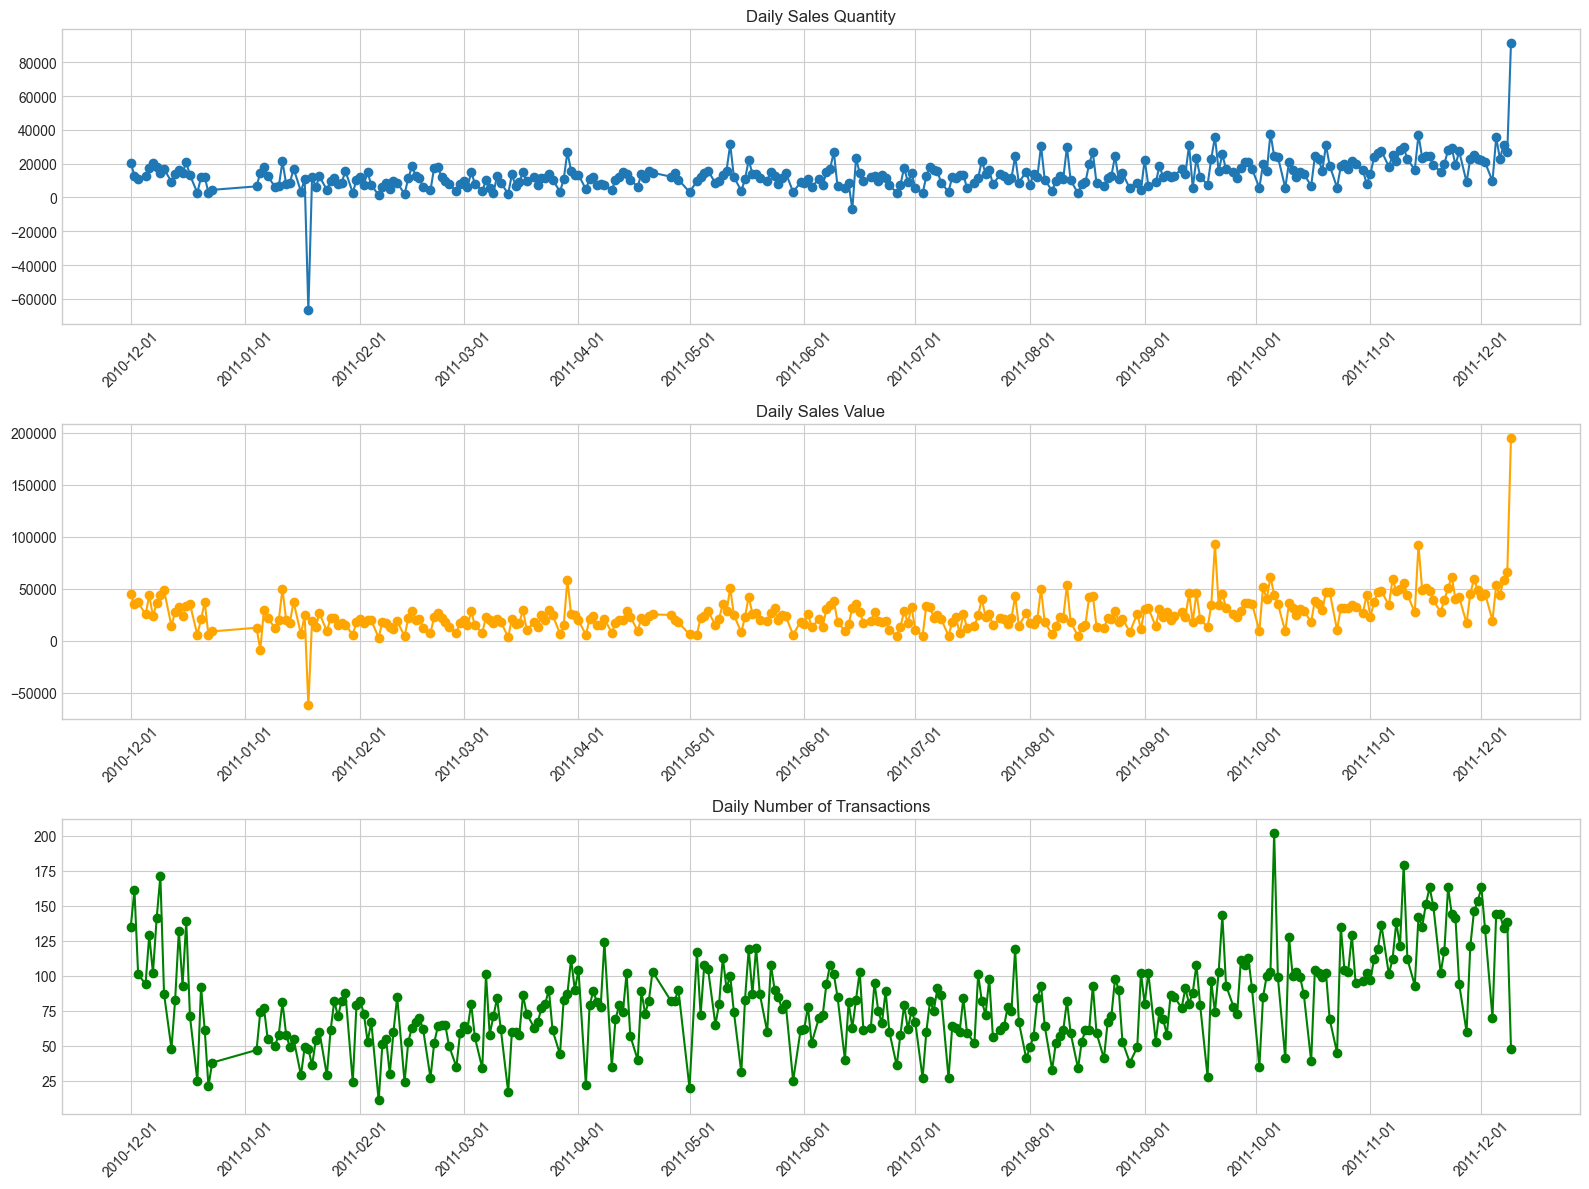

In [7]:
# Plot daily sales trends
plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.plot(daily_sales['Date'], daily_sales['DailySalesQuantity'], marker='o', linestyle='-')
plt.title('Daily Sales Quantity')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
plt.plot(daily_sales['Date'], daily_sales['DailySalesValue'], marker='o', linestyle='-', color='orange')
plt.title('Daily Sales Value')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
plt.plot(daily_sales['Date'], daily_sales['DailyTransactions'], marker='o', linestyle='-', color='green')
plt.title('Daily Number of Transactions')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


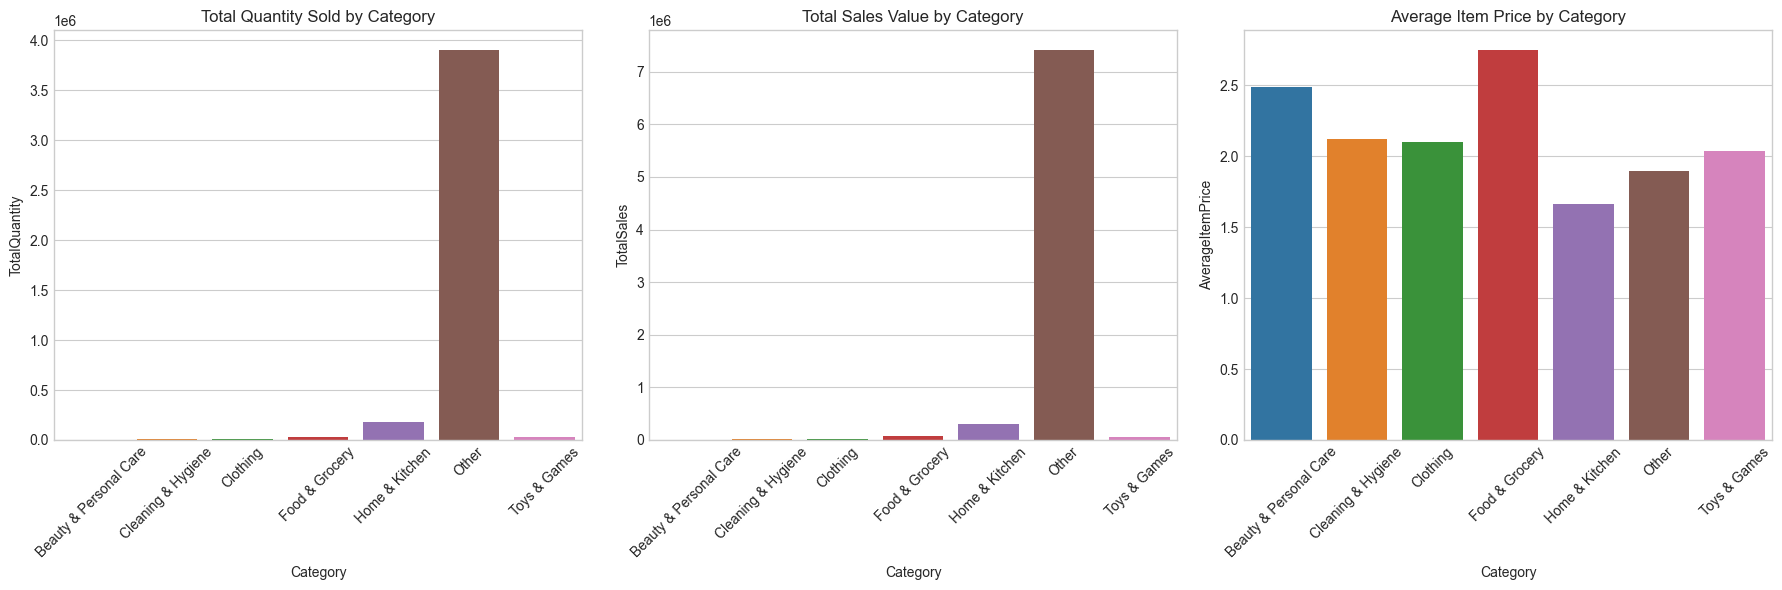

In [43]:
def extract_category(description):
    description = str(description).lower()
    if 'food' in description or 'grocery' in description or 'snack' in description:
        return 'Food & Grocery'
    elif 'clean' in description or 'soap' in description or 'wash' in description:
        return 'Cleaning & Hygiene'
    elif 'toy' in description or 'game' in description:
        return 'Toys & Games'
    elif 'cloth' in description or 'wear' in description or 'shirt' in description:
        return 'Clothing'
    elif 'home' in description or 'decor' in description or 'kitchen' in description:
        return 'Home & Kitchen'
    elif 'beauty' in description or 'cosmetic' in description:
        return 'Beauty & Personal Care'
    else:
        return 'Other'

# Apply the function to create a category column
df['ProductCategory'] = df['Description'].apply(extract_category)

# Analyze sales by category
category_sales = df.groupby('ProductCategory').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index()

category_sales.columns = ['Category', 'TotalQuantity', 'TotalSales', 'NumberOfTransactions']
category_sales['AverageItemPrice'] = category_sales['TotalSales'] / category_sales['TotalQuantity']

# Visualize category sales
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='Category', y='TotalQuantity', data=category_sales)
plt.title('Total Quantity Sold by Category')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(x='Category', y='TotalSales', data=category_sales)
plt.title('Total Sales Value by Category')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.barplot(x='Category', y='AverageItemPrice', data=category_sales)
plt.title('Average Item Price by Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

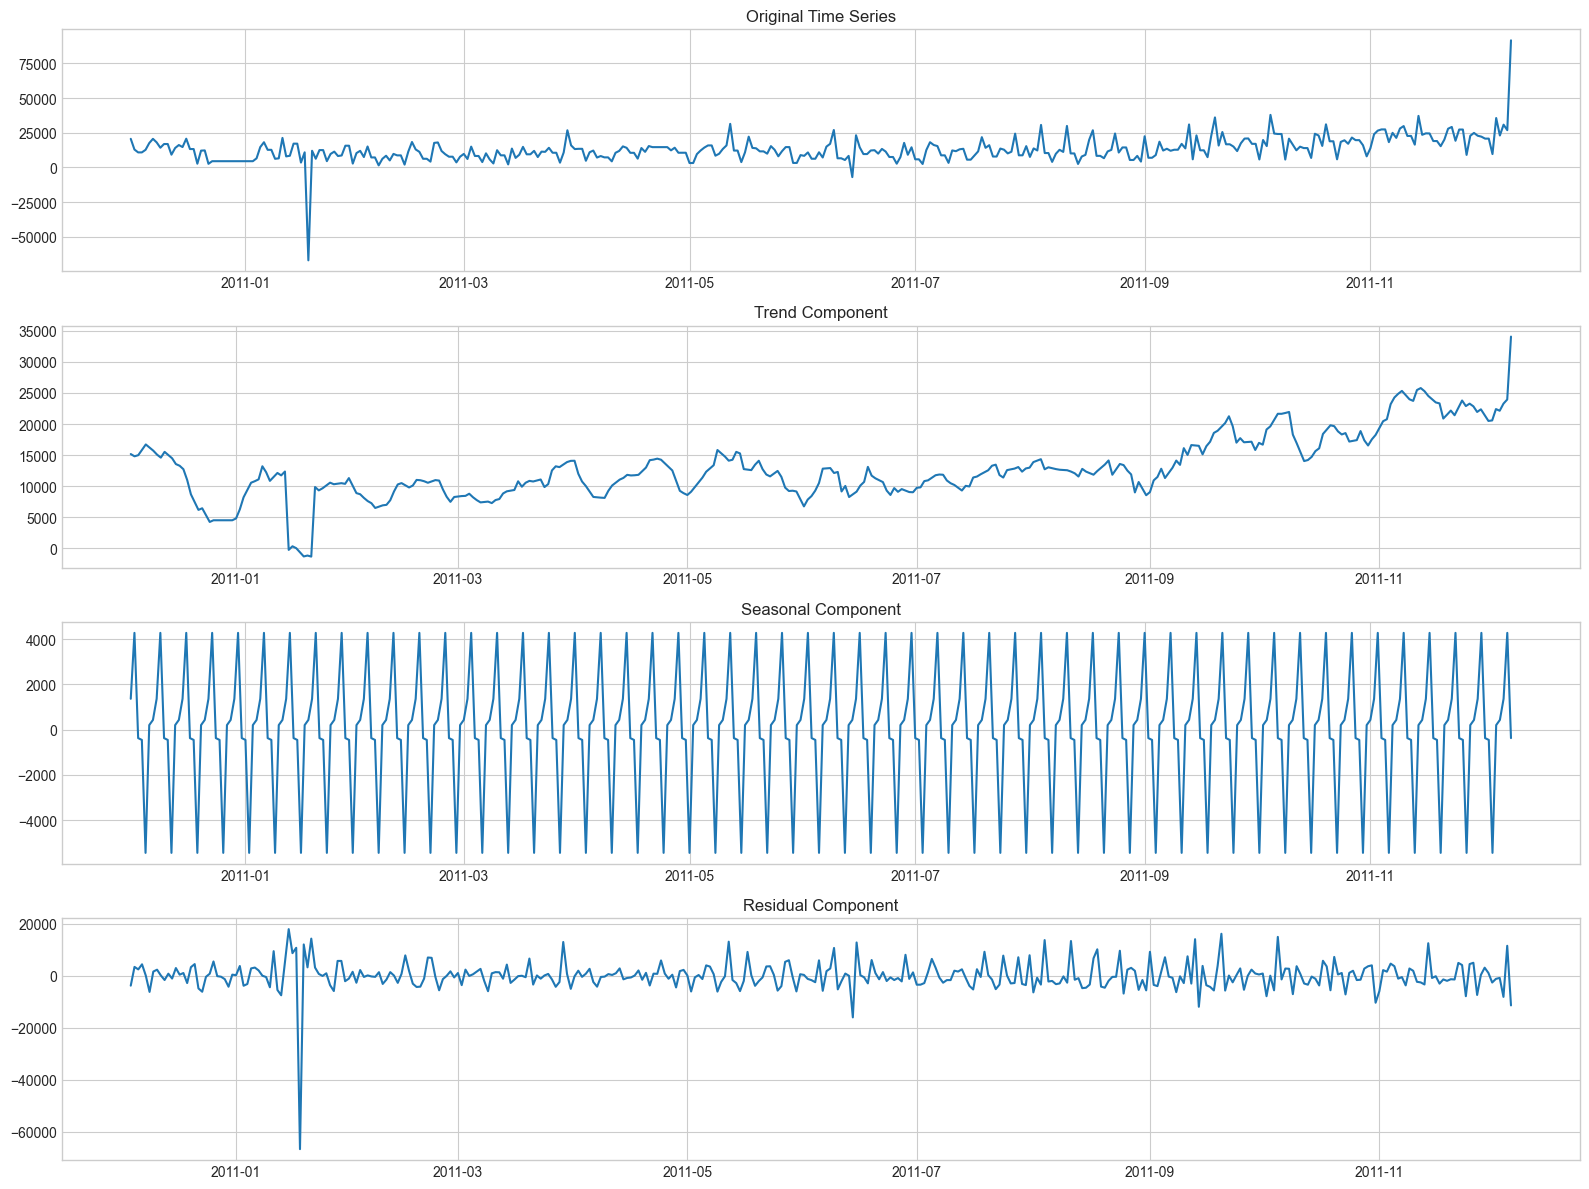

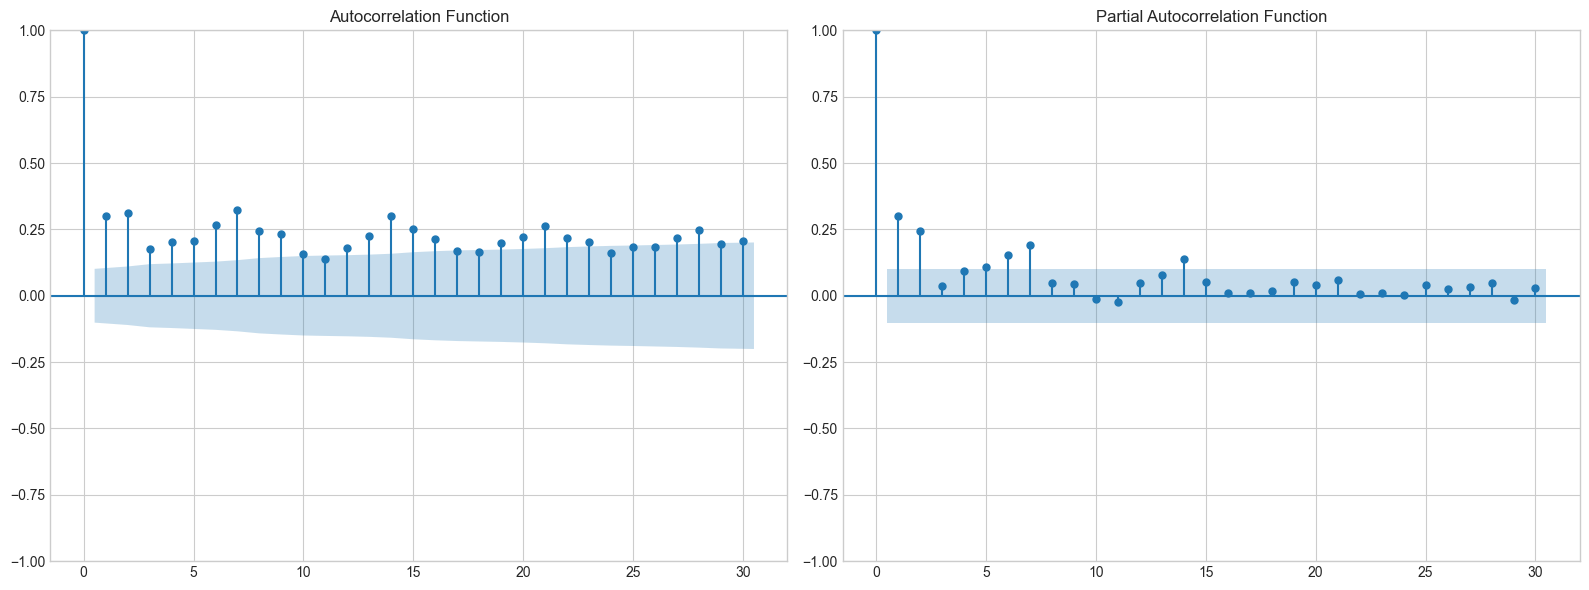

In [9]:
daily_sales.set_index('Date', inplace=True)

# Check for missing dates and fill them
date_range = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max())
daily_sales = daily_sales.reindex(date_range)
daily_sales.fillna(method='ffill', inplace=True)  # Forward fill for simplicity

# Perform time series decomposition
decomposition = seasonal_decompose(daily_sales['DailySalesQuantity'], model='additive', period=7)

# Plot the decomposition
plt.figure(figsize=(16, 12))

plt.subplot(4, 1, 1)
plt.plot(daily_sales.index, daily_sales['DailySalesQuantity'])
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual Component')

plt.tight_layout()
plt.show()

# ACF and PACF plots to identify time series patterns
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot_acf(daily_sales['DailySalesQuantity'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(1, 2, 2)
plot_pacf(daily_sales['DailySalesQuantity'].dropna(), lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()



--- Training Demand Forecasting Model (Quantity) ---
Mean Squared Error: 177451793.01
Root Mean Squared Error: 13321.10
Mean Absolute Error: 8819.30
R² Score: -0.49


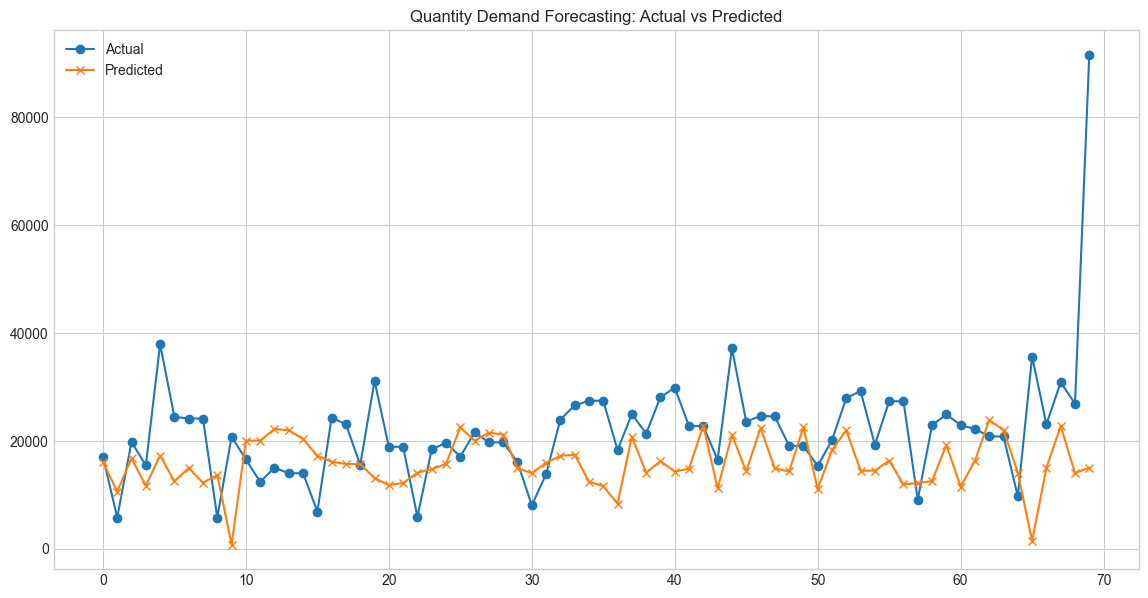

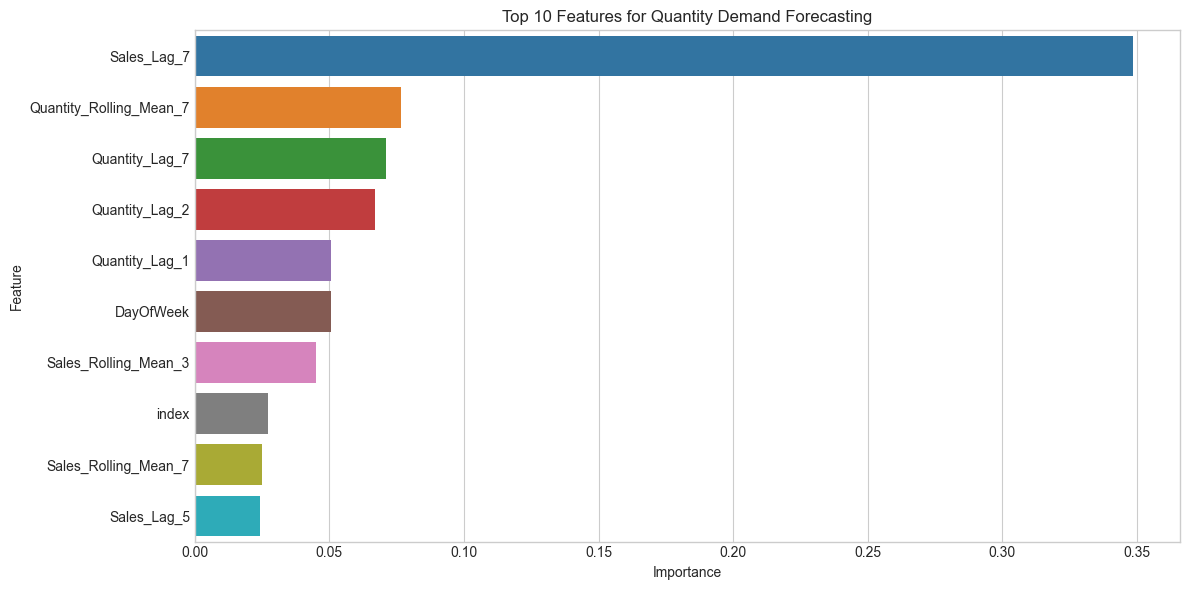

In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming daily_sales is your dataframe

# Convert datetime column 'index' to numeric values if it's a datetime type
# Extract the numerical components from the 'index' column (datetime)
daily_sales['DayOfWeek'] = daily_sales['index'].dt.dayofweek  # Monday=0, Sunday=6
daily_sales['Month'] = daily_sales['index'].dt.month
daily_sales['Year'] = daily_sales['index'].dt.year
daily_sales['DayOfMonth'] = daily_sales['index'].dt.day

# Create lag features
for lag in range(1, 8):  # Create lags up to 7 days
    daily_sales[f'Quantity_Lag_{lag}'] = daily_sales['DailySalesQuantity'].shift(lag)
    daily_sales[f'Sales_Lag_{lag}'] = daily_sales['DailySalesValue'].shift(lag)

# Create rolling window features
for window in [3, 7, 14]:
    daily_sales[f'Quantity_Rolling_Mean_{window}'] = daily_sales['DailySalesQuantity'].rolling(window=window).mean().shift(1)
    daily_sales[f'Sales_Rolling_Mean_{window}'] = daily_sales['DailySalesValue'].rolling(window=window).mean().shift(1)

# Drop NA values after creating lag features
daily_sales.dropna(inplace=True)

# Prepare features and target variable
X = daily_sales.drop(['DailySalesQuantity', 'DailySalesValue', 'DailyTransactions'], axis=1)  # Removed 'Date'
y_quantity = daily_sales['DailySalesQuantity']
y_value = daily_sales['DailySalesValue']

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_quantity_train, y_quantity_test = y_quantity[:train_size], y_quantity[train_size:]
y_value_train, y_value_test = y_value[:train_size], y_value[train_size:]

# Training a model to predict quantity
print("\n--- Training Demand Forecasting Model (Quantity) ---")

# We use XGBoost, which is generally well-suited for regression tasks
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_quantity_train)

# Make predictions
quantity_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_quantity_test, quantity_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_quantity_test, quantity_pred)
r2 = r2_score(y_quantity_test, quantity_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Visualize predictions vs actual
plt.figure(figsize=(14, 7))
plt.plot(y_quantity_test.values, label='Actual', marker='o')
plt.plot(quantity_pred, label='Predicted', marker='x')
plt.title('Quantity Demand Forecasting: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance visualization
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features for Quantity Demand Forecasting')
plt.tight_layout()
plt.show()


In [11]:
print(daily_sales.columns)


Index(['index', 'DailySalesQuantity', 'DailySalesValue', 'DailyTransactions'], dtype='object')



--- ARIMA Time Series Forecasting ---
Searching for optimal ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=7357.333, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7261.058, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=7190.043, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=7355.543, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=7192.665, Time=0.28 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=7210.618, Time=0.41 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=7188.754, Time=0.92 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=7192.891, Time=0.51 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=7354.425, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=7215.621, Time=0.30 sec
 ARIMA(0,1,2)(1,0,0)[7] intercept

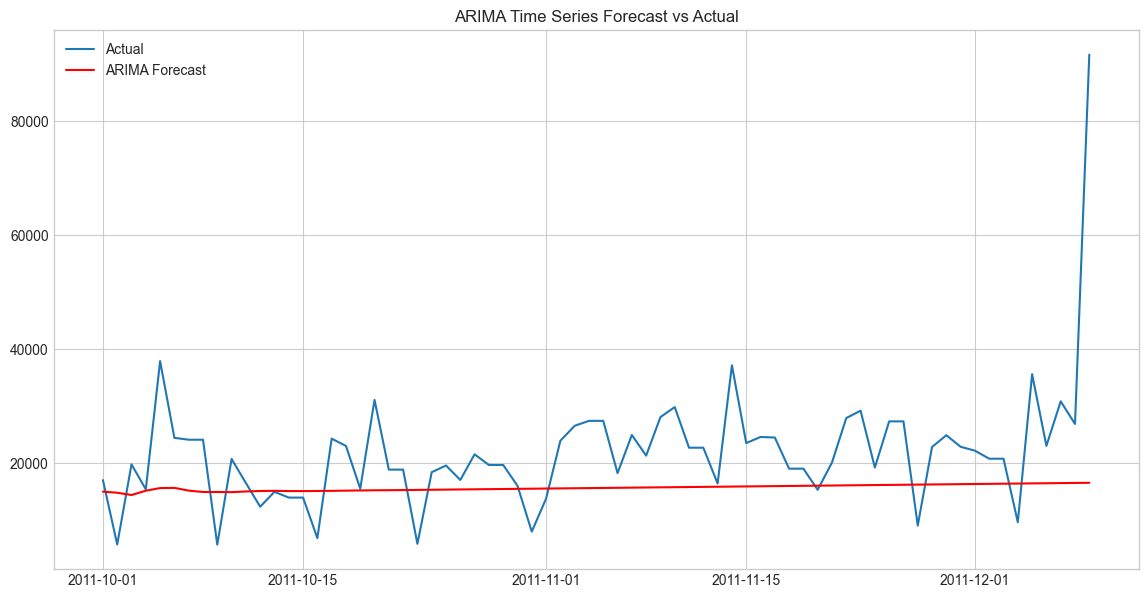

In [16]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# ARIMA Time Series Forecasting
# -----------------------------

print("\n--- ARIMA Time Series Forecasting ---")
print("Searching for optimal ARIMA parameters...")

# Set the datetime index (already exists as 'index' column)
ts_data = daily_sales.set_index('index')['DailySalesQuantity']

# Find the best ARIMA model
arima_model = auto_arima(
    ts_data,
    seasonal=True,
    m=7,  # Weekly seasonality
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    max_order=None,
    trace=True
)

print(f"\nBest ARIMA model: {arima_model}")

# Split data for ARIMA
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

# Fit the model
arima_model.fit(train_data)

# Forecast
forecast_steps = len(test_data)
arima_forecast = arima_model.predict(n_periods=forecast_steps)

# Evaluate ARIMA forecast
arima_mse = mean_squared_error(test_data, arima_forecast)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test_data, arima_forecast)

print(f"\nARIMA Mean Squared Error: {arima_mse:.2f}")
print(f"ARIMA Root Mean Squared Error: {arima_rmse:.2f}")
print(f"ARIMA Mean Absolute Error: {arima_mae:.2f}")

# Plot ARIMA forecast vs actual
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Time Series Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
print("\n--- Classification Approach to Demand Thresholds ---")

# Define a threshold for "high demand"
quantity_threshold = daily_sales['DailySalesQuantity'].quantile(0.75)
print(f"High demand threshold (75th percentile): {quantity_threshold:.2f}")

# Create binary target
daily_sales['HighDemand'] = (daily_sales['DailySalesQuantity'] >= quantity_threshold).astype(int)

# Prepare features and target for classification
X_class = daily_sales.drop(['DailySalesQuantity', 'DailySalesValue', 'DailyTransactions', 'HighDemand'], axis=1)
y_class = daily_sales['HighDemand']

# Train-test split (chronological)
X_class_train, X_class_test = X_class[:train_size], X_class[train_size:]
y_class_train, y_class_test = y_class[:train_size], y_class[train_size:]

# Train a classification model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_class_train, y_class_train)

# Make predictions
class_pred = rf_classifier.predict(X_class_test)
class_pred_prob = rf_classifier.predict_proba(X_class_test)[:, 1]

# Calculate classification metrics
accuracy = rf_classifier.score(X_class_test, y_class_test)
precision = precision_score(y_class_test, class_pred)
recall = recall_score(y_class_test, class_pred)
f1 = f1_score(y_class_test, class_pred)
auc_roc = roc_auc_score(y_class_test, class_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_class_test, class_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_class_test, class_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for High Demand Classification')
plt.legend()
plt.show()



--- Classification Approach to Demand Thresholds ---
High demand threshold (75th percentile): 16714.00


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

In [19]:
print(daily_sales.dtypes)


index                       datetime64[ns]
DailySalesQuantity                 float64
DailySalesValue                    float64
DailyTransactions                  float64
DayOfWeek                            int64
Month                                int64
Year                                 int64
DayOfMonth                           int64
Quantity_Lag_1                     float64
Sales_Lag_1                        float64
Quantity_Lag_2                     float64
Sales_Lag_2                        float64
Quantity_Lag_3                     float64
Sales_Lag_3                        float64
Quantity_Lag_4                     float64
Sales_Lag_4                        float64
Quantity_Lag_5                     float64
Sales_Lag_5                        float64
Quantity_Lag_6                     float64
Sales_Lag_6                        float64
Quantity_Lag_7                     float64
Sales_Lag_7                        float64
Quantity_Rolling_Mean_3            float64
Sales_Rolli

In [20]:
daily_sales = daily_sales.reset_index()
daily_sales = daily_sales.drop(columns=['index'])  # drop if you don't need it


In [21]:
X_class = daily_sales.drop(['DailySalesQuantity', 'DailySalesValue', 'DailyTransactions', 'HighDemand'], axis=1)
y_class = daily_sales['HighDemand']


High demand threshold (75th percentile): 17031.25
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.961
Precision: 0.8627
Recall (Sensitivity): 0.9167
F1 Score: 0.8889
AUC-ROC: 0.9154


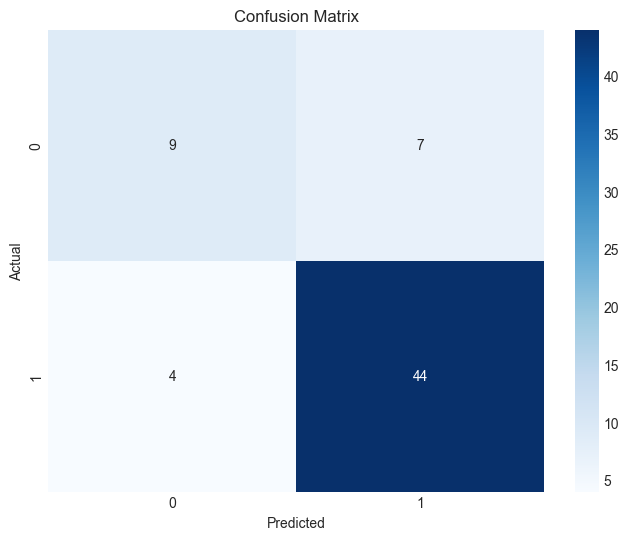

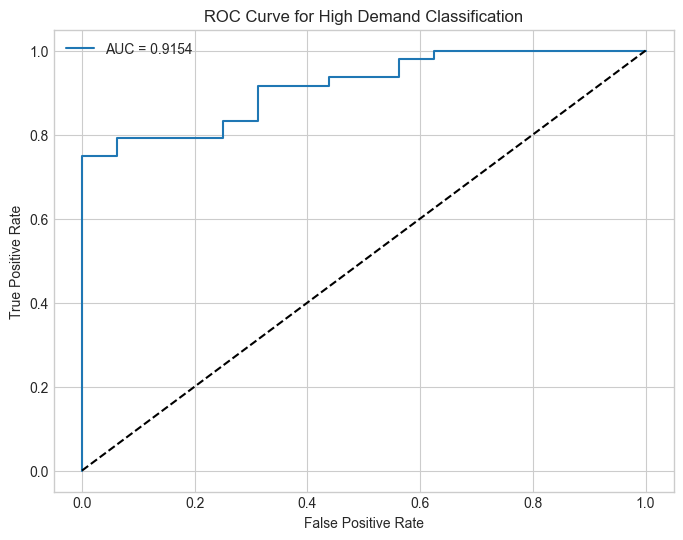

Cross-validation Accuracy: 0.8415
Ensemble Model Accuracy: 0.8906


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score


for lag in range(1, 8): 
    daily_sales[f'Quantity_Lag_{lag}'] = daily_sales['DailySalesQuantity'].shift(lag)
    daily_sales[f'Sales_Lag_{lag}'] = daily_sales['DailySalesValue'].shift(lag)

daily_sales['Quantity_Rolling_Mean_3'] = daily_sales['DailySalesQuantity'].rolling(window=3).mean()
daily_sales['Sales_Rolling_Mean_3'] = daily_sales['DailySalesValue'].rolling(window=3).mean()

daily_sales = daily_sales.dropna()

quantity_threshold = daily_sales['DailySalesQuantity'].quantile(0.75)
print(f"High demand threshold (75th percentile): {quantity_threshold:.2f}")

daily_sales['HighDemand'] = (daily_sales['DailySalesQuantity'] >= quantity_threshold).astype(int)

X_class = daily_sales.drop(['DailySalesQuantity', 'DailySalesValue', 'DailyTransactions', 'HighDemand'], axis=1)
y_class = daily_sales['HighDemand']

train_size = int(len(X_class) * 0.8)
X_class_train, X_class_test = X_class[:train_size], X_class[train_size:]
y_class_train, y_class_test = y_class[:train_size], y_class[train_size:]

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=2)

grid_search.fit(X_class_train, y_class_train)
print("Best Parameters:", grid_search.best_params_)

best_rf_classifier = grid_search.best_estimator_

class_pred = best_rf_classifier.predict(X_class_test)
class_pred_prob = best_rf_classifier.predict_proba(X_class_test)[:, 1]

accuracy = best_rf_classifier.score(X_class_test, y_class_test)
precision = precision_score(y_class_test, class_pred)
recall = recall_score(y_class_test, class_pred)
f1 = f1_score(y_class_test, class_pred)
auc_roc = roc_auc_score(y_class_test, class_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

cm = confusion_matrix(y_class_test, class_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, _ = roc_curve(y_class_test, class_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for High Demand Classification')
plt.legend()
plt.show()

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_rf_classifier, X_class, y_class, cv=tscv, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores.mean():.4f}")


log_reg = LogisticRegression(max_iter=1000, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42)

voting_clf = VotingClassifier(estimators=[('rf', best_rf_classifier), ('log_reg', log_reg), ('xgb', xgb)], voting='soft')
voting_clf.fit(X_class_train, y_class_train)

ensemble_accuracy = voting_clf.score(X_class_test, y_class_test)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")




--- Product-Level Demand Forecasting ---
Top 5 products by sales volume:
           Quantity
StockCode          
23843         80995
22197         45008
85099B        37671
84077         36196
85123A        30362


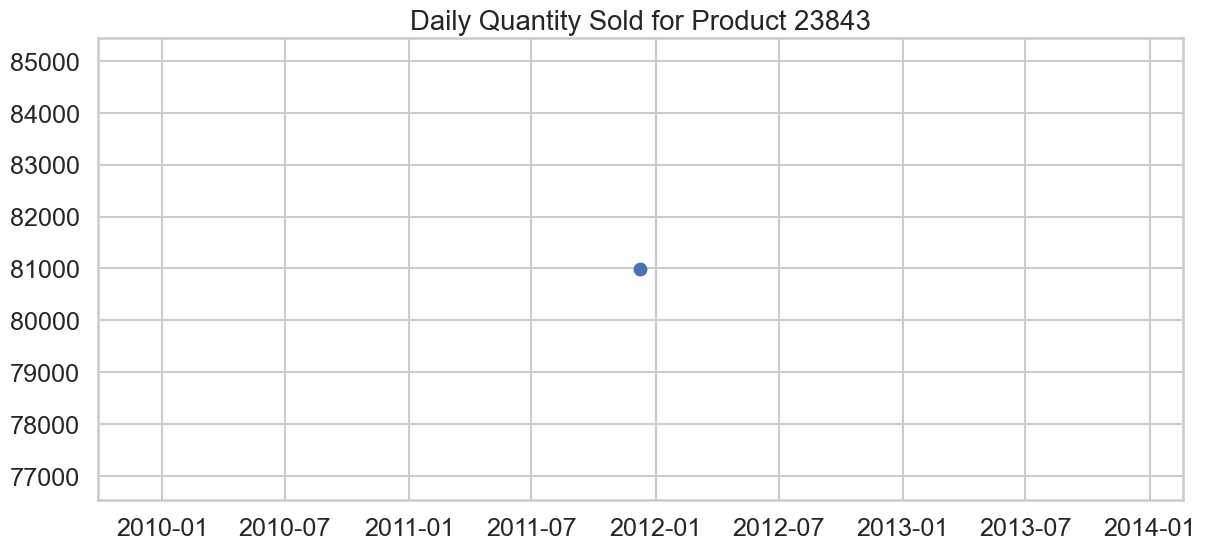

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("\n--- Product-Level Demand Forecasting ---")

# Top 5 products by total quantity sold
top_products = df.groupby('StockCode').agg({'Quantity': 'sum'}).sort_values('Quantity', ascending=False).head(5)
print("Top 5 products by sales volume:")
print(top_products)

top_product_code = top_products.index[0]
top_product_data = df[df['StockCode'] == top_product_code]

top_product_daily = top_product_data.groupby(top_product_data['InvoiceDate'].dt.date).agg({
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()

top_product_daily.columns = ['Date', 'DailyQuantity', 'DailySales']
top_product_daily['Date'] = pd.to_datetime(top_product_daily['Date'])

plt.figure(figsize=(14, 6))
plt.plot(top_product_daily['Date'], top_product_daily['DailyQuantity'], marker='o')
plt.title(f'Daily Quantity Sold for Product {top_product_code}')
plt.grid(True)
plt.show()


In [ ]:
print("\n--- Summary and Recommendations ---")
print("Based on our analysis, we recommend the following actions for Kirana stores:")
print("1. Focus on high-demand products identified in our analysis")
print("2. Optimize inventory levels based on our time series forecasts")
print("3. Consider day-of-week patterns when planning promotions")
print("4. Track and leverage product category performance")
print("5. Implement automated reorder systems using our predictive models")

print("\nModel Performance Comparison:")
print(f"XGBoost Regression RMSE: {rmse:.2f}")
print(f"ARIMA Time Series RMSE: {arima_rmse:.2f}")
print(f"Classification Accuracy: {accuracy:.4f}")

print("\nFuture Improvements:")
print("1. Incorporate external factors like holidays, promotions, and weather")
print("2. Implement deep learning models for more complex patterns")
print("3. Develop a hybrid approach combining time series and ML methods")
print("4. Create an interactive dashboard for store owners")


--- Summary and Recommendations ---
Based on our analysis, we recommend the following actions for Kirana stores:
1. Focus on high-demand products identified in our analysis
2. Optimize inventory levels based on our time series forecasts
3. Consider day-of-week patterns when planning promotions
4. Track and leverage product category performance
5. Implement automated reorder systems using our predictive models

Model Performance Comparison:
XGBoost Regression RMSE: 13321.10
ARIMA Time Series RMSE: 12365.41
Classification Accuracy: 0.961

Future Improvements:
1. Incorporate external factors like holidays, promotions, and weather
2. Implement deep learning models for more complex patterns
3. Develop a hybrid approach combining time series and ML methods
4. Create an interactive dashboard for store owners
